# $B_z$ extraction is simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys
from scipy import optimize
sys.path.append("../CommonUtils/")
import CommonUtils as cu

### Define constants and starting fit parameters

In [2]:
bin_w = 150*1e-3 # 150 ns 
x_min = 0 # us  #TODO 30 for data 
x_max = 100 # us 
p_min = 1800 # MeV 
p_max = 3100 # MeV 

print("Starting and end times [us]:", x_min, "to", x_max)
print("P cuts [MeV]:", p_min, "to", p_max)

omega_a = 1.43934 # MHz (magic)
cu._omega=omega_a #for BNL fits
print("Magic omega set to", cu._omega, "MHz")

g2period = 2*np.pi / omega_a   # 4.3653 us 
print("g2period [us]:", g2period)

Starting and end times [us]: 0 to 100
P cuts [MeV]: 1800 to 3100
Magic omega set to 1.43934 MHz
g2period [us]: 4.365323903441568


### Load HDF5 data and apply time and momentum cuts

In [3]:
#long time to open 1st time
# %time data = pd.read_hdf("../DATA/HDF/Sim/VLEDM.h5", columns=("trackT0", "station", "trackMomentum", "trackMomentumY") )

# #save to open skimed
# data.to_hdf("../DATA/HDF/Sim/VLEDM_skim.h5", key="sim", mode='w', complevel=9, complib="zlib", format="fixed")

#open skimmed 
data = pd.read_hdf("../DATA/HDF/Sim/VLEDM_skim.h5")
mom_cut = ( (data['trackMomentum'] > p_min) & (data['trackMomentum'] < p_max) ) # MeV  
time_cut =( (data['trackT0'] > x_min) & (data['trackT0'] < x_max) ) # MeV  
data=data[mom_cut & time_cut]
N=data.shape[0] 
print("Total tracks", N)

#TODO for data
#define station cuts to loop over TODO fpr data
# s12_cut = (data['station'] == stations[0])
# s18_cut = (data['station'] == stations[1])
# station_cut = (s12_cut, s18_cut)

Total tracks 1106538


### Resolve variables

In [4]:
p=data['trackMomentum']
py=data['trackMomentumY']
t=data['trackT0']
mod_times = cu.get_g2_mod_time(t) # Module the g-2 oscillation time 
theta_y = np.arctan2(py, p)
data['mod_times']=mod_times
data['theta_y']=theta_y

# data

### Digitise data

In [5]:
count_binw=0.01 # us 
bin_c, freq = cu.get_freq_bin_c_from_data(mod_times, count_binw, (0, g2period) )
y_err = np.sqrt(freq)

### Plot counts vs. mod time and fit

In [6]:
#set vars, fit pars, and fot
x,y,y_e = bin_c, freq, y_err
# p0=(5000, 60 , -0.4, omega_a, 6.24)
p0=(5000, 60 , -0.4, 6.24)
par, par_e, chi2_ndf = cu.fit_and_chi2(x, y, y_e, cu.unblinded_wiggle_fixed, p0)

Params: [ 2.616e+03  6.494e+01 -3.857e-01  6.295e+00]
Errors: [1.629e+01 1.171e+01 1.999e-03 1.104e-02]
𝝌2/dof=2.5


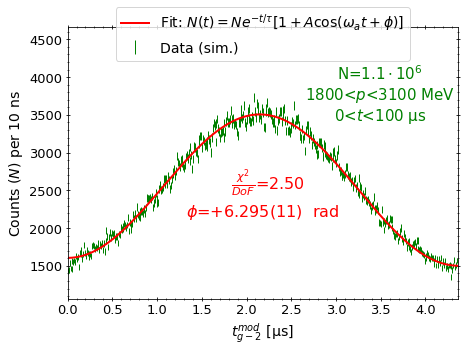

In [7]:
font_size=14
fig, ax = cu.plot(bin_c, freq, y_err=y_err, error=True, elw=1, label="Data (sim.)", fs=font_size, tight=False,
                  xlabel=r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]", ylabel=r"Counts ($N$) per "+str(int(count_binw*1e3))+" ns")
ax.plot(bin_c, cu.unblinded_wiggle_fixed(bin_c, *par), c="red", 
        label=r'Fit: $N(t)=Ne^{-t/\tau}[1+A\cos(\omega_at+\phi)]$', lw=2)
ax.set_xlim(0, g2period);
ax.set_ylim(np.amin(freq)*0.9, np.amax(freq)*1.25);
leg_fit=cu.legend1_fit(chi2_ndf)
leg_fit=cu.legend_1par(leg_fit, r"$\phi$", par[-1], par_e[-1], " rad", prec=3)
leg_data="N="+cu.sci_notation(N)+"\n"+str(p_min)+r"<$p$<"+str(p_max)+" MeV\n"+str(x_min)+r"<$t$<"+str(x_max)+r" $\mathrm{\mu}$s"
ax.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.5, 1.1));
cu.textL(ax, 0.5, 0.35, leg_fit, c="r", fs=font_size+2)
cu.textL(ax, 0.8, 0.75, leg_data, fs=font_size+1)
fig.savefig("../fig/bnl_fit.png", dpi=300)

### Set constant phase for the next step

In [8]:
cu._phi=par[-1]
print("Phase set to", cu._phi, "rad")

Phase set to 6.2946151440107725 rad


### Profile the $\langle\theta_y\rangle$, fit and plot

In [9]:
theta_y_bins=len(bin_c) # set same N of bins 
theta_y_bin_w = int(round(g2period/theta_y_bins*1e3)) #sanity
df_binned =cu.Profile(mod_times, theta_y, None, nbins=theta_y_bins, xmin=np.min(mod_times), xmax=np.max(mod_times), mean=True, only_binned=True)
x=df_binned['bincenters']
y=df_binned['ymean']*1e3
y_e=df_binned['yerr']*1e3
x_e=df_binned['xerr']

In [10]:
# p0=[0.00, 0.13, 0.05, 1.44]
p0=[0.00, 0.17, 0.1]
par, par_e, chi2_ndf = cu.fit_and_chi2(x, y, y_e, cu.thetaY_unblinded_phase, p0)

Params: [-0.043  0.142  0.042]
Errors: [0.018 0.017 0.013]
𝝌2/dof=1.1


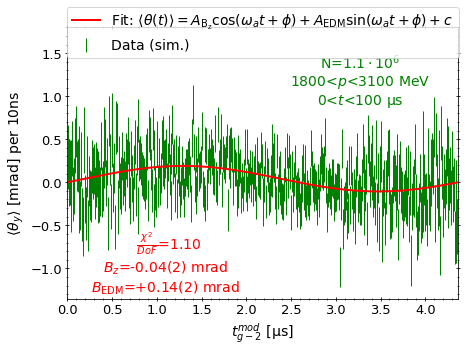

In [11]:
fig, ax = cu.plot(x, y, y_err=y_e, error=True, elw=1, label="Data (sim.)", fs=font_size, tight=False,
                  xlabel=r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]",  ylabel=r"$\langle\theta_y\rangle$ [mrad] per "+str(theta_y_bin_w)+ "ns")
ax.plot(x, cu.thetaY_unblinded_phase(x, *par), c="red", 
        label=r'Fit: $\langle \theta(t) \rangle =  A_{\mathrm{B_z}}\cos(\omega_a t + \phi) + A_{\mathrm{EDM}}\sin(\omega_a t + \phi) + c$', lw=2)
ax.set_xlim(0, g2period);
ax.set_ylim(-np.amax(y)*1.5, np.amax(y)*2.0);
leg_data="N="+cu.sci_notation(N)+"\n"+str(p_min)+r"<$p$<"+str(p_max)+" MeV\n"+str(x_min)+r"<$t$<"+str(x_max)+r" $\mathrm{\mu}$s"
ax.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.5, 1.1));
cu.textL(ax, 0.75, 0.8, leg_data, fs=font_size)
leg_fit=cu.legend1_fit(chi2_ndf)
leg_fit=cu.legend_1par(leg_fit, r"$B_z$", par[0], par_e[0], "mrad")
leg_fit=cu.legend_1par(leg_fit, r"$B_{\mathrm{EDM}}$", par[1], par_e[1], "mrad")
cu.textL(ax, 0.25, 0.1, leg_fit, fs=font_size, c="r")
fig.savefig("../fig/bz_fit.png", dpi=300)

In [12]:
# gm2_asym = 0.45 
# ang_amp = 1.0
# cos_amp = 1. / np.sqrt(2)
# sin_amp = np.sqrt(1 - np.power(cos_amp, 2))
# p0_ver=(ang_amp, cos_amp, omega_a, cu._phi, sin_amp)

# def f_vertical(t, *pars):
#     N=pars[0]
#     A_w=pars[1]
#     omega=pars[2]
#     phi=pars[3]
#     A_edm=pars[4]
#     return N*( A_w*np.cos(omega*t+phi) + A_edm*np.sin(omega*t+phi))